In [1]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

In [2]:
from Calculation.StationaryState import StationaryState   
        
st_state = StationaryState()

In [3]:
H1k1_hyst = 7.5e3
H1k2_hyst = 6.5e3
H2k_hyst = 12.5e3

thickness = 12e-7
Ms_hyst = 620.

Ku_1ord, Ku_2ord, J_hyst = Hk2KuJ(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, thickness)

#setting up film parameters
film_inst_single = LayeredFilm.from_file('default_single')
film_inst_double = LayeredFilm.from_file('default_double')

film_inst_single.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=True)
film_inst_double.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=False)


print("single layered")
film_inst_single.print()
print("double layered")
film_inst_double.print()

single layered
---------------------------------------------------
sample parametrs:
	J = 0.00

	layer1 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------
double layered
---------------------------------------------------
sample parametrs:
	J = 1.86

	layer1 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------


In [4]:
H = symbols("H", real=True, positive=True)
Htet, Hphi = symbols("theta_H phi_H", real=True)
Ms = symbols("Ms", real=True, positive=True)
Mtet = symbols("theta_M1 theta_M2", real=True)
Mphi = symbols("phi_M1 phi_M2", real=True)
A, Ku2, gamma, alpha = symbols("A K_u2 gamma alpha", real=True, positive=True)
J = symbols("J", real=True)
Hk1, Hk2, H2k = symbols("H_k1 H_k2 H2_k", real=True, positive=True)
t = symbols("t", real=True, positive=True)

In [5]:
Ev1 = -Ms * H * (sym.sin(Htet) * sym.sin(Mtet[0]) * sym.cos(Hphi - Mphi[0]) +
                 sym.cos(Htet) * sym.cos(Mtet[0])) + \
      A * (sym.sin(Mtet[0]) ** 2) + \
      Ku2 * (sym.sin(Mtet[0]) ** 4)

Ev2 = -Ms * H * (sym.sin(Htet) * sym.sin(Mtet[1]) * sym.cos(Hphi - Mphi[1]) +
                 sym.cos(Htet) * sym.cos(Mtet[1])) + \
      A * (sym.sin(Mtet[1]) ** 2) + \
      Ku2 * (sym.sin(Mtet[1]) ** 4)

Es = t * Ev1 + t * Ev2 + \
     J * (sym.sin(Mtet[0]) * sym.sin(Mtet[1]) * sym.cos(Mphi[1] - Mphi[0]) +
          sym.cos(Mtet[0]) * sym.cos(Mtet[1]))

In [6]:
sys_mat = np.zeros((4,4), dtype=sym.Add)

sys_vars = [Mtet[0], Mphi[0], Mtet[1], Mphi[1]]
diff_vars = [Mphi[0], Mtet[0], Mphi[1], Mtet[1]]
for i in range(4):
    for j in range(4):
        sys_mat[i][j] = (gamma / Ms) * (1 / t) * Es.diff(diff_vars[i], sys_vars[j])
        if i%2==1:
            sys_mat[i][j] = -sys_mat[i][j]

lamb = symbols("lambda", complex=True)

for i in range(2):
    sys_mat[i][i] += lamb*sym.sin(Mtet[0])
    
for i in range(2, 4):
    sys_mat[i][i] += lamb*sym.sin(Mtet[1])

sys_mat[0][1] += alpha*lamb*sym.sin(Mtet[0])**2
sys_mat[2][3] += alpha*lamb*sym.sin(Mtet[1])**2

sys_mat[1][0] += -alpha*lamb
sys_mat[3][2] += -alpha*lamb
    
sys_mat = sym.Matrix(sys_mat)

# subs for PMA
sys_mat = sys_mat.subs({
    Hphi: 0, Mphi[0]: 0, Mphi[1]: 0
})
sys_mat = sys_mat.subs({
    Ku2: Ms * Hk2 / 4,
    A: Ms * (Hk1 - Hk2) / 2,
    J: (t / 2) * Ms * (H2k - Hk1)
})
sys_mat.simplify()

In [7]:
sym.factor(sym.expand(sys_mat))

Matrix([
[                                                                                                                                                                                                                                     lambda*sin(theta_M1), H*gamma*sin(theta_H)*sin(theta_M1) - H2_k*gamma*sin(theta_M1)*sin(theta_M2)/2 + H_k1*gamma*sin(theta_M1)*sin(theta_M2)/2 + alpha*lambda*sin(theta_M1)**2,                                                                                                                                                                                                                                                         0,                                                                      H2_k*gamma*sin(theta_M1)*sin(theta_M2)/2 - H_k1*gamma*sin(theta_M1)*sin(theta_M2)/2],
[-H*gamma*cos(theta_H - theta_M1) + H2_k*gamma*cos(theta_M1 - theta_M2)/2 + 2*H_k1*gamma*sin(theta_M1)**2 - H_k1*gamma*cos(theta_M1 - theta_M2)/2 - H_k1*gamma + 4*H_k2*gamma*sin(t

In [8]:
sys_det = sys_mat.det(method='berkowitz')
sys_det_collected = sym.collect(sym.expand(sys_det), lamb)
pows = []
for i in range(5):
    pows.append(sys_det_collected.coeff(lamb, i))

In [9]:
p4 = sym.factor(pows[4]).subs({alpha**2: 0})

In [10]:
#p4

In [11]:
p3 = sym.collect(sym.expand(pows[3]), gamma)
p3 = sym.factor(sym.collect(p3, alpha)).subs({1+alpha**2: 1})
p3 = sym.expand(sym.expand_trig(p3))
p3 = sym.simplify(sym.factor(p3))

In [12]:
#p3

In [13]:
p2 = sym.collect(sym.expand(pows[2]), gamma)
p2 = sym.collect(p2, alpha).subs({alpha**2: 0})
p2 = sym.expand(sym.expand_trig(p2))
p2 = sym.simplify(sym.factor(p2))

In [14]:
#p2

In [15]:
p1 = sym.collect(sym.expand(pows[1]), gamma)
p1 = sym.collect(p1, alpha)
p1 = sym.expand(sym.expand_trig(p1))
p1 = sym.factor(p1)

In [16]:
#p1

In [17]:
p0 = sym.collect(sym.expand(pows[0]), gamma)
p0 = simplify(sym.factor(sym.expand_trig(p0)))

In [18]:
#p0

In [19]:
p0_sym, p1_sym, p2_sym, p3_sym, p4_sym = symbols("p_0 p_1 p_2 p_3 p_4", real=True)
p_syms = [p0_sym, p1_sym, p2_sym, p3_sym, p4_sym]
w_sym = symbols("w", real=True)

w_sol = sym.solve(p4_sym*(w_sym**4) - p2_sym*(w_sym**2) + p0_sym, w_sym)

for i in range(4):
    w_sol[i] = w_sol[i].subs({
        p4_sym: p4,
        p2_sym: p2,
        p0_sym: p0
    })

In [20]:
w_sol[1]

sqrt(2)*sqrt(gamma**2*(8*H**2*sin(theta_H)**2*sin(theta_M1)*sin(theta_M2) + 4*H**2*sin(theta_H)*sin(theta_M1 + theta_M2)*cos(theta_H) - 4*H*H2_k*sin(theta_H)*sin(theta_M1)**2*sin(theta_M2) - 4*H*H2_k*sin(theta_H)*sin(theta_M1)*sin(theta_M2)**2 - 2*H*H2_k*sin(theta_M1)*sin(theta_H + theta_M1)*cos(theta_M2) - 2*H*H2_k*sin(theta_M2)*sin(theta_H + theta_M2)*cos(theta_M1) - 4*H*H_k1*sin(theta_H)*sin(theta_M1)**2*sin(theta_M2) - 4*H*H_k1*sin(theta_H)*sin(theta_M1)*sin(theta_M2)**2 + 4*H*H_k1*sin(theta_H)*sin(theta_M1) + 4*H*H_k1*sin(theta_H)*sin(theta_M2) + 2*H*H_k1*sin(theta_M1)*sin(theta_H + theta_M1)*cos(theta_M2) + 2*H*H_k1*sin(theta_M2)*sin(theta_H + theta_M2)*cos(theta_M1) - 16*H*H_k2*sin(theta_H)*sin(theta_M1)**4*sin(theta_M2) + 20*H*H_k2*sin(theta_H)*sin(theta_M1)**2*sin(theta_M2) - 16*H*H_k2*sin(theta_H)*sin(theta_M1)*sin(theta_M2)**4 + 20*H*H_k2*sin(theta_H)*sin(theta_M1)*sin(theta_M2)**2 - 4*H*H_k2*sin(theta_H)*sin(theta_M1) - 4*H*H_k2*sin(theta_H)*sin(theta_M2) + H2_k**2*sin(thet

In [21]:
varset = (
    H, Htet,
    Ms, Mtet[0], Mtet[1],
    Hk1, Hk2, H2k,
    t,
    gamma
)

f_sol_lamb = []
for eq in w_sol:
    f_sol_lamb.append(sym.lambdify(varset, eq/(2*sym.pi), 'numpy'))

In [22]:
class LinearDoubleResults:
    def __init__(self, film_inst):
        Htet = np.deg2rad(63.)
        Habses = np.linspace(1e3, 5e3, 100)
        self.Hax = Habses
        
        self.res_freq = []
        
        for f_lamb in (f_sol_lamb[1],):
            res_freq_tmp = []
            for Habs in Habses:
                Hext = pol2cart(Habs, Htet, 0.)
                
                angles = st_state.get_angles_optimize(
                    film_inst,
                    Hext,
                    tol=1e-8
                )
                
                res_freq_tmp.append(
                    f_lamb(
                        Habs, Htet,
                        film_inst.l1.st.Ms, angles[0], angles[2],
                        H1k1_hyst, H1k2_hyst, H2k_hyst,
                        film_inst.l1.st.t,
                        film_inst.l1.st.gamma
                    )
                )
            self.res_freq.append(res_freq_tmp)
            
        
results_double = LinearDoubleResults(film_inst_double)

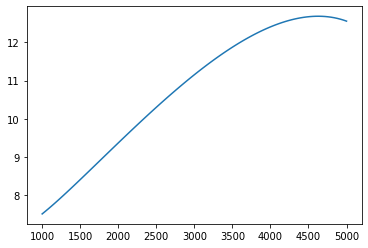

In [23]:
plt.plot(results_double.Hax, np.array(results_double.res_freq[0])*1e-9)
#results_double.res_freq[0]

In [24]:
beta_sym = symbols('beta', real=True)

In [25]:
lamb_im = []
lamb_im.append(0)

for i in range(1, 5):
    tmp = sym.expand((sym.I*w_sym-beta_sym)**i)
    lamb_im.append(sym.cancel(sym.im(tmp)/w_sym))

for im in lamb_im:
    display(im)

0

1

-2*beta

3*beta**2 - w**2

-4*beta**3 + 4*beta*w**2

In [26]:
eq = sym.Rational(0, 1)
for i in range(5):
    eq+=lamb_im[i]*p_syms[i]

eq = sym.collect(sym.expand(eq), beta_sym)
eq

-4*beta**3*p_4 + 3*beta**2*p_3 + beta*(-2*p_2 + 4*p_4*w**2) + p_1 - p_3*w**2

In [27]:
b_sol = sym.solve(eq, beta_sym)

In [28]:
for i in range(len(b_sol)):
    b_sol[i] = b_sol[i].subs({
        p4_sym: p4,
        p3_sym: p3,
        p2_sym: p2,
        p1_sym: p1,
        p0_sym: p0
    })

In [29]:
varset = (
    H, Htet,
    Ms, Mtet[0], Mtet[1],
    Hk1, Hk2, H2k,
    t,
    gamma, alpha, w_sym
)

b_sol_lamb = []
for eq in b_sol:
    b_sol_lamb.append(sym.lambdify(varset, eq, 'numpy'))

In [30]:
class BetaResults:
    def __init__(self, film_inst):
        Htet = np.deg2rad(63.)
        Habses = np.linspace(1e3, 5e3, 100)
        self.Hax = Habses
        
        self.res_beta = []
        
        for b_lamb in (b_sol_lamb):
            res_beta_tmp = []
            for Habs in Habses:
                Hext = pol2cart(Habs, Htet, 0.)
                
                angles = st_state.get_angles_optimize(
                    film_inst,
                    Hext,
                    tol=1e-8
                )
                
                cur_freq = f_sol_lamb[1](
                    Habs, Htet,
                    film_inst.l1.st.Ms, angles[0], angles[2],
                    H1k1_hyst, H1k2_hyst, H2k_hyst,
                    film_inst.l1.st.t,
                    film_inst.l1.st.gamma
                )
                
                res_beta_tmp.append(
                    b_lamb(
                        Habs, Htet,
                        film_inst.l1.st.Ms, angles[0], angles[2],
                        H1k1_hyst, H1k2_hyst, H2k_hyst,
                        film_inst.l1.st.t,
                        film_inst.l1.st.gamma,
                        film_inst.l1.st.alpha,
                        2*np.pi*cur_freq
                    )
                )
            self.res_beta.append(res_beta_tmp)
            
        
results_beta = BetaResults(film_inst_double)

In [40]:
tau_exp_d = np.array([
    100,
    100,
    91,
    60,
    63
])

tau_num_s = np.array([
    109.8,
    84.0,
    76.6,
    71.2,
    64.9
])

tau_num_d = np.array([
    110.2,
    89.7,
    85.5,
    87.1,
    92.2
])

dr_exp = pd.read_csv('data/moke/double_results_experimental.txt', sep='\t')
dr_exp

,H,A1,f,df,tau_f,d_tau_f,A2,tau2,A3,tau3
0,1530,2.4,8.7,0.3,113.7,20.5,3.7,226.8,693,3044395
1,2295,4.3,9.8,0.2,115.0,16.0,5.0,202.0,3800,2947127
2,3060,5.5,11.0,0.2,114.0,16.0,8.7,349.0,-,-
3,3825,7.6,12.2,0.2,63.7,5.0,15.0,237.0,-,-
4,4590,11.0,12.9,0.1,73.6,4.0,19.8,217.0,-,-


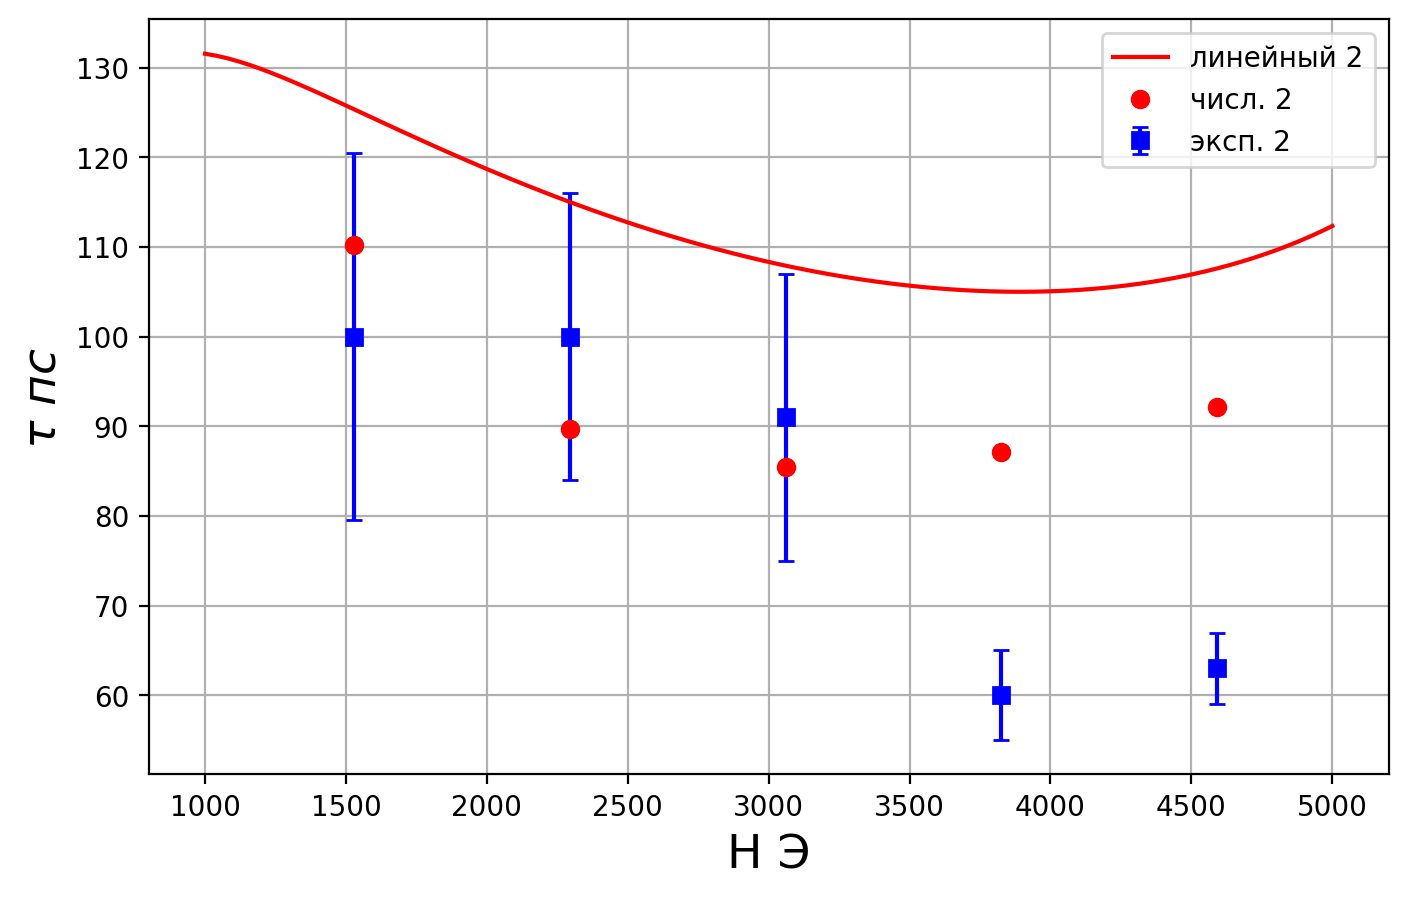

In [47]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)

plt.plot(results_beta.Hax, 1e12/np.array(results_beta.res_beta[0]), label='линейный 2', color='r')
#plt.plot(results_beta.Hax, 1e12/np.array(results_beta.res_beta[1]), label='линейный 2')# getting complex values
#plt.plot(results_beta.Hax, 1e12/np.array(results_beta.res_beta[2]), label='линейный 2')# getting complex values
plt.plot(dr_exp.H, tau_num_d, 'ro', label='числ. 2')
#plt.errorbar(dr_exp.H, dr_exp.tau_f, yerr=2*dr_exp.d_tau_f,fmt='bs', label='эксп. 2')
plt.errorbar(dr_exp.H, tau_exp_d, yerr=dr_exp.d_tau_f, fmt='bs', label='эксп. 2',elinewidth=1.5, capsize=3)
plt.xlabel('H Э',fontsize=17)
plt.ylabel(r"$\tau\ пс$",fontsize=17)
plt.grid(True)
plt.legend()

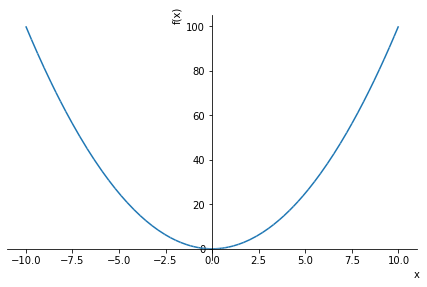

In [225]:
x = symbols("x", real = True)
tmpf = p0_sym*x + p1_sym*x**2
plot(tmpf.subs({
    p0_sym: 0,
    p1_sym: 1
}))